In [6]:
#!pip install translate langdetect pyspellchecker spacy

### Description

In part-1 of the notebook we have done all the data cleaning and NLP text preprocessing like tokenizing , stop words removal,lemmatization , tf-idf .

In this part-2 of the notebook , We perform **dimensionality reduction** using truncated SVD , **feature selection** as well as **model training and evaluation**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
import time
from datetime import datetime
import re
import os
from translate import Translator
from langdetect import detect
from nltk.corpus import words
from spellchecker import SpellChecker
from nltk import FreqDist
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import ast
from wordcloud import WordCloud
from nltk.corpus import stopwords
#import spacy
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2 , mutual_info_classif
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score




In [2]:
lemmatized_df = pd.read_csv('category_df_lemmatized_version_2.csv')
lemmatized_df.head()

,final_processed_location,category
0,"['atm', 'mandri']",atms
1,"['atm', 'mandiri']",atms
2,"['mandiri', 'atm']",atms
3,"['atmbank', 'mandiri']",atms
4,['bankmandiriatm'],atms


In [3]:
target_variable = lemmatized_df['category']

In [3]:
tfidf_df = pd.read_parquet('tf_idf_category_dataset.parquet')
tfidf_df.head()

,10th,10thousand,13th,13unce,1800motorcycle,18tropicana,19place,1altitude,1colony,1mg,...,zzyzx,zén,électrick,ćaf,บภ,สสร,เก,เมโกร,แพร,ไทย
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print('Lemmatized rows : {}\ntfidf rows : {}'.format(len(lemmatized_df),len(tfidf_df)))

Lemmatized rows : 35154
tfidf rows : 35154


#### 3.5 Dimensionality Reduction

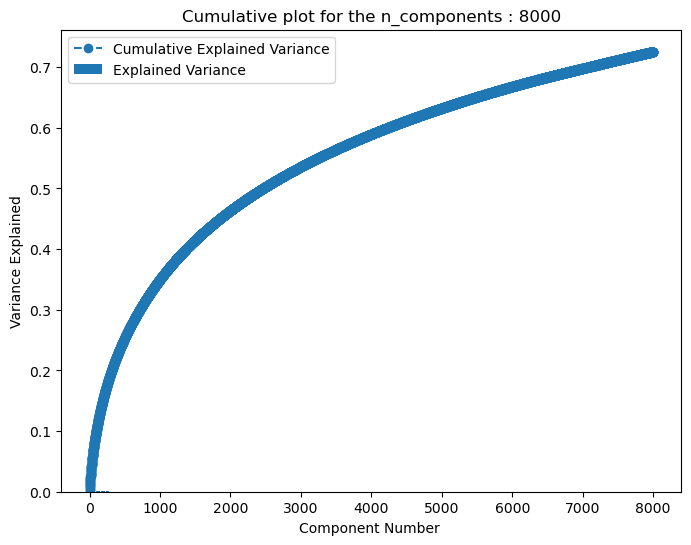

In [9]:
n_component_list= [i for i in range(8000, 10000 , 2000 )]

def cumulative_plot(explained_variance,cumulative_explained_variance, n_component):
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, label='Explained Variance')
    plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative Explained Variance', linestyle='--')
    plt.xlabel('Component Number ')
    plt.ylabel('Variance Explained')
    plt.title('Cumulative plot for the n_components : {}'.format(n_component))
    plt.legend()
    plt.show()
    
    
def dimensionality_reduction(n_component_list):
    
    X_svd_list = {}
    explained_variance_list ={}
    cumulative_explained_variance_list = {}
    
    for i in n_component_list:
        svd = TruncatedSVD(n_components=i)  # Adjust the number of components
        X_svd = svd.fit_transform(tfidf_df)
        X_svd_list[i]=X_svd
        
        # access the variance it covers by the n features
        explained_variance = svd.explained_variance_ratio_
        
        cumulative_explained_variance = explained_variance.cumsum()
        
        cumulative_plot(explained_variance,cumulative_explained_variance,i)
        
    return X_svd_list, explained_variance_list , cumulative_explained_variance_list

        
X_svd_list, explained_variance_list , cumulative_explained_variance_list=dimensionality_reduction(n_component_list)     

    
        
        



In [11]:
X_svd_list[8000]

array([[ 6.39195281e-04,  2.57703677e-04,  7.89026374e-03, ...,
         2.33898271e-04,  4.23734092e-04, -6.70281526e-04],
       [ 9.04055272e-04,  3.14724214e-04,  9.59289015e-03, ...,
         9.51588250e-04,  4.80793985e-04,  5.35893800e-05],
       [ 9.04055272e-04,  3.14724214e-04,  9.59289015e-03, ...,
         9.51588250e-04,  4.80793985e-04,  5.35893800e-05],
       ...,
       [ 4.21928972e-02,  5.42655325e-03,  5.13010406e-03, ...,
         4.83333694e-04, -1.82027809e-03, -6.81176284e-04],
       [ 1.08430770e-02,  6.80855543e-04,  2.17532395e-02, ...,
        -1.40032572e-03,  4.78048943e-03,  1.83131759e-02],
       [ 2.20118006e-04,  3.06112960e-05,  2.57325192e-04, ...,
        -1.90007898e-03, -8.19992577e-04,  2.30878193e-03]])

In [12]:
X_svd_df = pd.DataFrame(X_svd_list[8000])
X_svd_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,0.000639,0.000258,0.007890,0.000403,-0.004366,0.000871,0.001839,-0.000732,0.002949,0.006025,...,0.001275,0.000499,-0.000216,0.000403,-0.001226,-0.000997,0.000277,0.000234,0.000424,-0.000670
1,0.000904,0.000315,0.009593,0.000348,-0.005347,0.000871,0.002306,-0.000912,0.003480,0.007330,...,0.000711,0.000886,0.000533,-0.000438,0.000091,0.000634,0.000314,0.000952,0.000481,0.000054
2,0.000904,0.000315,0.009593,0.000348,-0.005347,0.000871,0.002306,-0.000912,0.003480,0.007330,...,0.000711,0.000886,0.000533,-0.000438,0.000091,0.000634,0.000314,0.000952,0.000481,0.000054


In [15]:
X_svd_df = X_svd_df.rename(columns=lambda x: str(x))


In [17]:
X_svd_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,6.391953e-04,2.577037e-04,7.890264e-03,4.029789e-04,-4.365569e-03,8.709757e-04,1.839152e-03,-7.322817e-04,2.948728e-03,6.024913e-03,...,0.001275,0.000499,-0.000216,0.000403,-0.001226,-0.000997,0.000277,0.000234,0.000424,-0.000670
1,9.040553e-04,3.147242e-04,9.592890e-03,3.478231e-04,-5.346885e-03,8.705949e-04,2.305574e-03,-9.124770e-04,3.479638e-03,7.330380e-03,...,0.000711,0.000886,0.000533,-0.000438,0.000091,0.000634,0.000314,0.000952,0.000481,0.000054
2,9.040553e-04,3.147242e-04,9.592890e-03,3.478231e-04,-5.346885e-03,8.705949e-04,2.305574e-03,-9.124770e-04,3.479638e-03,7.330380e-03,...,0.000711,0.000886,0.000533,-0.000438,0.000091,0.000634,0.000314,0.000952,0.000481,0.000054
3,1.406798e-04,1.860479e-05,5.204293e-04,-1.101649e-04,-3.596270e-04,-9.243620e-05,1.546868e-04,-6.260461e-05,1.103869e-04,4.441878e-04,...,-0.003442,0.000291,-0.003526,0.012687,-0.005387,-0.001027,-0.000176,-0.008409,-0.010085,0.003708
4,3.001999e-15,1.008053e-14,-1.399287e-14,3.022575e-13,-1.565221e-13,1.534733e-13,2.557993e-13,-8.895552e-14,-4.288397e-13,3.836539e-13,...,-0.019121,-0.012636,0.016747,0.013358,0.000444,-0.018158,-0.010821,-0.015495,0.009894,-0.011989


In [41]:
X_svd_df.to_parquet('category_df_svd_version.parquet',index=False)

In [31]:
X_svd_df.shape

(35154, 8000)

In [35]:
X_svd_df_32_bit = X_svd_df.astype(np.float32)
X_svd_df_32_bit.head(3)

,0,1,2,3,4,5,6,7,8,9,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,0.000639,0.000258,0.007890,0.000403,-0.004366,0.000871,0.001839,-0.000732,0.002949,0.006025,...,0.001275,0.000499,-0.000216,0.000403,-0.001226,-0.000997,0.000277,0.000234,0.000424,-0.000670
1,0.000904,0.000315,0.009593,0.000348,-0.005347,0.000871,0.002306,-0.000912,0.003480,0.007330,...,0.000711,0.000886,0.000533,-0.000438,0.000091,0.000634,0.000314,0.000952,0.000481,0.000054
2,0.000904,0.000315,0.009593,0.000348,-0.005347,0.000871,0.002306,-0.000912,0.003480,0.007330,...,0.000711,0.000886,0.000533,-0.000438,0.000091,0.000634,0.000314,0.000952,0.000481,0.000054


In [37]:
X_svd_df_16_bit = X_svd_df.astype(np.float16)
X_svd_df_32_bit.head(3)

,0,1,2,3,4,5,6,7,8,9,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,0.000639,0.000258,0.007890,0.000403,-0.004366,0.000871,0.001839,-0.000732,0.002949,0.006025,...,0.001275,0.000499,-0.000216,0.000403,-0.001226,-0.000997,0.000277,0.000234,0.000424,-0.000670
1,0.000904,0.000315,0.009593,0.000348,-0.005347,0.000871,0.002306,-0.000912,0.003480,0.007330,...,0.000711,0.000886,0.000533,-0.000438,0.000091,0.000634,0.000314,0.000952,0.000481,0.000054
2,0.000904,0.000315,0.009593,0.000348,-0.005347,0.000871,0.002306,-0.000912,0.003480,0.007330,...,0.000711,0.000886,0.000533,-0.000438,0.000091,0.000634,0.000314,0.000952,0.000481,0.000054


In [43]:
X_svd_df_32_bit.to_parquet('category_svd_16bit_version.parquet',index=False)

In [32]:
tfidf_df.shape

(35154, 30781)

#### 3.5 Feature Selection

##### Mutual Information Technique for feature selection

In [4]:
X_svd_df_32_bit=pd.read_parquet('category_svd_32bit_version.parquet')
X_svd_df_32_bit.head(3)

,0,1,2,3,4,5,6,7,8,9,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,0.000639,0.000258,0.007890,0.000403,-0.004366,0.000871,0.001839,-0.000732,0.002949,0.006025,...,0.001275,0.000499,-0.000216,0.000403,-0.001226,-0.000997,0.000277,0.000234,0.000424,-0.000670
1,0.000904,0.000315,0.009593,0.000348,-0.005347,0.000871,0.002306,-0.000912,0.003480,0.007330,...,0.000711,0.000886,0.000533,-0.000438,0.000091,0.000634,0.000314,0.000952,0.000481,0.000054
2,0.000904,0.000315,0.009593,0.000348,-0.005347,0.000871,0.002306,-0.000912,0.003480,0.007330,...,0.000711,0.000886,0.000533,-0.000438,0.000091,0.000634,0.000314,0.000952,0.000481,0.000054


In [8]:
# The number of top features to select
selector = SelectKBest(score_func=mutual_info_classif , k=200)
X_fs = selector.fit_transform(X_svd_df_32_bit, target_variable)

X_fs_df = pd.DataFrame(X_fs)

KeyboardInterrupt: 

**Note** Feature selection is consuming a lot of time , due to time crunch I am ignoring the step.

In [ ]:
X_fs_df.head()

### 4. Training and Evaluating the model 

In [6]:
def build_multiclass_classifier(X, y, classifier, test_size=0.2, random_state=None, n_jobs=-1):
    
    try:
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Train the classifier on the training data
        classifier.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = classifier.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)

        # Macro-averaged(computes for each class then takes the unweighted average)
        # precision ,recall, f1-score
        macro_precision = precision_score(y_test, y_pred, average='macro')
        macro_recall = recall_score(y_test, y_pred, average='macro')
        macro_f1 = f1_score(y_test, y_pred, average='macro')

        # Cross-validation to estimate model's generalization ability with parallel processing
        cv_accuracy = np.mean(cross_val_score(classifier, X, y, cv=5, n_jobs=n_jobs))

        # Create a dictionary to store evaluation metrics
        evaluation_metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Macro-Precision': macro_precision,
            'Macro-Recall': macro_recall,
            'Macro-F1 Score': macro_f1,
            'Confusion Matrix': cm,
            'Cross-Validation Accuracy': cv_accuracy
        }

        return evaluation_metrics

    except MemoryError as mem_error:
        return {'Error': f'MemoryError: {str(mem_error)}'}
    except Exception as e:
        return {'Error': f'An error occurred: {str(e)}'}



### 4.1 Applying Multinomial Naive Bayes Algorithm

##### Multinomial NB onTF-IDF data

In [ ]:
start_time = datetime.now()

# passing the tf-idf data and check the model performance
evaluation = build_multiclass_classifier(X=tfidf_df,y= target_variable, classifier=MultinomialNB(), test_size=0.2, random_state=42, n_jobs=-1)
print('Evaluation_metrics : ',evaluation)

time_taken = datetime.now()- start_time
print('Time taken to execute the model and evaulate using tf-idf data : {}'.format(time_taken))

##### Multinomial NB on Dimensionality reduction data

In [21]:
# passing the svd data and check the model performance
start_time = datetime.now()

evaluation_svf = build_multiclass_classifier(X=X_svd_df,y= target_variable, classifier=MultinomialNB(), test_size=0.2, random_state=42, n_jobs=-1)
print('Evaluation_metrics : ',evaluation2)

time_taken = datetime.now()- start_time
print('Time taken to execute the model and evaulate using tf-idf data : {}'.format(time_taken))

ValueError: Negative values in data passed to MultinomialNB (input X)

### 4.2 Applying RandomForestClassifer Algorithm

In [7]:
# Training the model on dimensional data and check the model performance
start_time = datetime.now()

evaluation2 = build_multiclass_classifier(X=X_svd_df_32_bit, y=target_variable, classifier=RandomForestClassifier(n_estimators=20, random_state=42), test_size=0.2, random_state=42, n_jobs=-1)
print('Evaluation_metrics : ',evaluation2)

time_taken = datetime.now()- start_time
print('Time taken to execute the model and evaulate using tf-idf data : {}'.format(time_taken))

Evaluation_metrics :  {'Accuracy': 0.35386147063006684, 'Precision': 0.3745105594902213, 'Recall': 0.35386147063006684, 'F1 Score': 0.3535525881806935, 'Macro-Precision': 0.3738909146514906, 'Macro-Recall': 0.3578588597212378, 'Macro-F1 Score': 0.35354452733418057, 'Confusion Matrix': array([[15,  1,  2, ...,  0,  0,  0],
       [ 0,  5,  1, ...,  0,  0,  0],
       [ 5,  0, 11, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 19,  0,  0],
       [ 0,  0,  0, ...,  0, 15,  0],
       [ 0,  0,  0, ...,  0,  0,  5]], dtype=int64), 'Cross-Validation Accuracy': 0.29183033964804916}
Time taken to execute the model and evaulate using tf-idf data : 4:40:08.587508


In [9]:
evaluation2['Confusion Matrix'].shape

(248, 248)

In [12]:
RFC_confusion_matrix_df= pd.DataFrame(evaluation2['Confusion Matrix'])
RFC_confusion_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,238,239,240,241,242,243,244,245,246,247
0,15,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,5,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,5,0,11,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,13,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
RFC_confusion_matrix_df.to_csv('RFC_confusion_matrix.csv')

### 4.3 Applying OneVsRestClassifer Algorithm

In [16]:
# Training the model on dimensional data and check the model performance
one_vs_rest_classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)

start_time = datetime.now()

evaluation3 = build_multiclass_classifier(X=X_svd_df_32_bit, y=target_variable, classifier=one_vs_rest_classifier, test_size=0.2, random_state=42, n_jobs=-1)
print('Evaluation_metrics : ',evaluation3)

time_taken = datetime.now()- start_time
print('Time taken to execute the model and evaulate using tf-idf data : {}'.format(time_taken))

KeyboardInterrupt: 

**Note** : Interrupting the execution due to submission deadline

### 5. Conclusion

The conclusion is we can experiment with multiple techniques to improve the model performance. 
1. By fine tuning the dimensionality reduction to improve the variance of the data
2. By applying the feature selection strategy effectively for better selection of features by using techniques like **mutual information or chi-square**
3. By increasing the precision from 32-bit to 64-bit values but at a cost of additional memory and computational power
4. Fine-tuning the **hyperparameters** such as n_estimators in RandomForestClassifier and alpha parameter in OneVsRestClassifer and several other parameters.
5. Also by fixing the **misspelled words** in the dataset
6. We can identify the classes which are predicted poorly and giving more additional weightage to them while training.


These are some of the techniques to improve that are commonly practiced.
